# Bike rental hourly count prediction (regression)
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic,
environmental and health issues.

#### Data 
The dataset contains information for hourly bike usage and weather conditions for full years 2023 and 2024. It is taken from 2 sources:
1. Hourly weather data from [Open Meteo API](https://open-meteo.com/en/docs/historical-weather-api).
2. [Bike usage data](https://s3.amazonaws.com/tripdata/index.html) in New York, which was aggregated by hourly basis and then merged to the weather data.

#### Dataset description
- id: record index
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (2023 or 2024)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- weekday : day of the week
- day : day of the month
- temp : Temperature in Celsius. 
- atemp: Feeling temperature in Celsius. 
- hum: Humidity. 
- windspeed: Wind speed.
- casual: count of casual users
- registered: count of registered users
- classic_bike: count of classic bikes
- electric_bike: count of electric bikes
- cnt: count of total rental bikes

We are going to do the following steps.
1. Use 5 different regression algorithms to predict the value of `cnt` column. We'll use randomly selected 90% train set and 10% test set for that.
2. After finding the best model we'll create training and test sets otherwise - the first year will be the training set and the second year will be the test set.
3. We'll train the best model on the first year and use the model to predict the `cnt` values of the second year.
4. We'll train the best model on the first year and use the model to predict the `casual` and `registered` values of the second year (multitarget regression).
5. We'll sum the predicted `casual` and `registered` values and use it as a prediction for `cnt` column (again for the second year).

## Imports and useful functions

In [1]:
import numpy as np
import pandas as pd
import math
import time

from sklearn.model_selection import  train_test_split
from sklearn import metrics

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt.pyll import scope


In [2]:
PATH = 'bike-weather-data.csv'
SEED = 1000
TARGET = 'cnt'
np.random.seed(SEED)

## Read data

In [3]:
df = pd.read_csv(PATH)
df.head()

,id,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
0,2023-12-1-0,4.6,0.4,14.3,0.0,69,1.0,2023.0,12.0,1.0,0.0,4.0,357.0,823.0,255.0,925.0,1180.0
1,2023-12-1-1,4.3,0.2,13.6,0.0,72,1.0,2023.0,12.0,1.0,1.0,4.0,214.0,478.0,159.0,533.0,692.0
2,2023-12-1-2,3.1,-0.3,9.2,0.0,79,1.0,2023.0,12.0,1.0,2.0,4.0,114.0,299.0,110.0,303.0,413.0
3,2023-12-1-3,2.5,-1.0,9.1,0.0,81,1.0,2023.0,12.0,1.0,3.0,4.0,55.0,217.0,55.0,217.0,272.0
4,2023-12-1-4,1.7,-1.7,8.3,0.0,84,1.0,2023.0,12.0,1.0,4.0,4.0,71.0,161.0,48.0,184.0,232.0


In [4]:
df.tail()

,id,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
17539,2024-12-31-21,8.0,5.2,10.8,0.0,82,4.0,2024.0,12.0,31.0,21.0,2.0,163.0,627.0,150.0,640.0,790.0
17540,2024-12-31-22,7.3,4.8,9.7,3.1,87,4.0,2024.0,12.0,31.0,22.0,2.0,50.0,207.0,51.0,206.0,257.0
17541,2024-12-31-23,7.3,4.5,12.2,2.8,91,4.0,2024.0,12.0,31.0,23.0,2.0,153.0,697.0,218.0,632.0,850.0
17542,2023-3-12-2,0.5,-4.8,19.2,0.0,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17543,2024-3-10-2,9.7,8.5,7.6,0.0,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing values
Let's see if there are missing values in the dataframe

In [5]:
df[df.isnull().any(axis=1)]

,id,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
17542,2023-3-12-2,0.5,-4.8,19.2,0.0,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17543,2024-3-10-2,9.7,8.5,7.6,0.0,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 2 such rows, most probably because of Daylight saving time, when clocks go forward, thus skipping one hour. Let's remove them.

In [6]:
df = df[df['cnt'].notna()]

Let's remove `id` column which is just an identifier and is not needed. Also I the column `day` (day of month) has no impact on bike sharing, I'll delete it too.

In [7]:
df.drop(['id', 'day'], inplace=True, axis=1)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17542 entries, 0 to 17541
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           17542 non-null  float64
 1   atemp          17542 non-null  float64
 2   windspeed      17542 non-null  float64
 3   precipitation  17542 non-null  float64
 4   hum            17542 non-null  int64  
 5   season         17542 non-null  float64
 6   yr             17542 non-null  float64
 7   mnth           17542 non-null  float64
 8   hr             17542 non-null  float64
 9   weekday        17542 non-null  float64
 10  classic_bike   17542 non-null  float64
 11  electric_bike  17542 non-null  float64
 12  casual         17542 non-null  float64
 13  registered     17542 non-null  float64
 14  cnt            17542 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 2.1 MB


No missing values, all features are numeric.

There are 4 more columns which aren't feautures. `casual` and `registered` are also some kind of targets, and their sum is equal to `cnt`. The same applies to `classic_bike` and `electric_bike`, their sum is also equal to `cnt`. We'll make a prediction for them later. But for now we'll use the remaining features to predict the value of `cnt` which is our target variable.

In [9]:
columns = df.columns.drop(['casual', 'registered', 'classic_bike', 'electric_bike', TARGET])
columns

Index(['temp', 'atemp', 'windspeed', 'precipitation', 'hum', 'season', 'yr',
       'mnth', 'hr', 'weekday'],
      dtype='object')

## Normalization
Let's normalize the columns `temp`, `atemp`, `windspeed`, `precipitation`, `hum` columns to have 0 to 1 values. Also let's use a value of "0" for the year 2023, and a value of "1" for the year 2024.

In [10]:
cols_to_norm = ['temp', 'atemp', 'windspeed', 'precipitation', 'hum']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df['yr'] = df['yr'].apply(lambda x: 0 if x == 2023 else 1)
df.head()

,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
0,0.401515,0.381250,0.249564,0.0,0.639535,1.0,0,12.0,0.0,4.0,357.0,823.0,255.0,925.0,1180.0
1,0.395833,0.378125,0.237347,0.0,0.674419,1.0,0,12.0,1.0,4.0,214.0,478.0,159.0,533.0,692.0
2,0.373106,0.370312,0.160558,0.0,0.755814,1.0,0,12.0,2.0,4.0,114.0,299.0,110.0,303.0,413.0
3,0.361742,0.359375,0.158813,0.0,0.779070,1.0,0,12.0,3.0,4.0,55.0,217.0,55.0,217.0,272.0
4,0.346591,0.348438,0.144852,0.0,0.813953,1.0,0,12.0,4.0,4.0,71.0,161.0,48.0,184.0,232.0


There are some columns that are treated as float by Pandas because initially they had missing values. Now we can set the type integer for them.

In [11]:
convert_dict = {'season': int, 'mnth': int, 'hr': int, 
                'weekday': int, 'classic_bike': int, 
                'electric_bike': int, 'casual': int, 
                'registered': int, 'cnt': int}
df = df.astype(convert_dict)
df.head()

,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
0,0.401515,0.381250,0.249564,0.0,0.639535,1,0,12,0,4,357,823,255,925,1180
1,0.395833,0.378125,0.237347,0.0,0.674419,1,0,12,1,4,214,478,159,533,692
2,0.373106,0.370312,0.160558,0.0,0.755814,1,0,12,2,4,114,299,110,303,413
3,0.361742,0.359375,0.158813,0.0,0.779070,1,0,12,3,4,55,217,55,217,272
4,0.346591,0.348438,0.144852,0.0,0.813953,1,0,12,4,4,71,161,48,184,232


## EDA

In [12]:
df.describe()

,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
count,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000
mean,0.558758,0.547550,0.219620,0.005959,0.650294,2.499430,0.500684,6.520237,11.501083,3.005131,787.828583,1099.997720,351.757838,1536.068464,1887.826303
std,0.176755,0.181606,0.113609,0.030347,0.223799,1.116229,0.500014,3.449641,6.922035,1.997854,824.965000,1032.355574,378.227948,1466.570462,1781.198491
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.416667,0.398438,0.134380,0.000000,0.476744,2.000000,0.000000,4.000000,6.000000,1.000000,134.000000,246.000000,66.000000,314.000000,392.250000
50%,0.558712,0.537500,0.198953,0.000000,0.662791,2.000000,1.000000,7.000000,12.000000,3.000000,503.500000,811.500000,226.000000,1108.500000,1373.000000
75%,0.704545,0.696875,0.284468,0.000000,0.848837,3.000000,1.000000,10.000000,17.750000,5.000000,1216.000000,1673.000000,510.000000,2394.750000,2961.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,12.000000,23.000000,6.000000,6352.000000,7776.000000,3290.000000,10229.000000,12738.000000


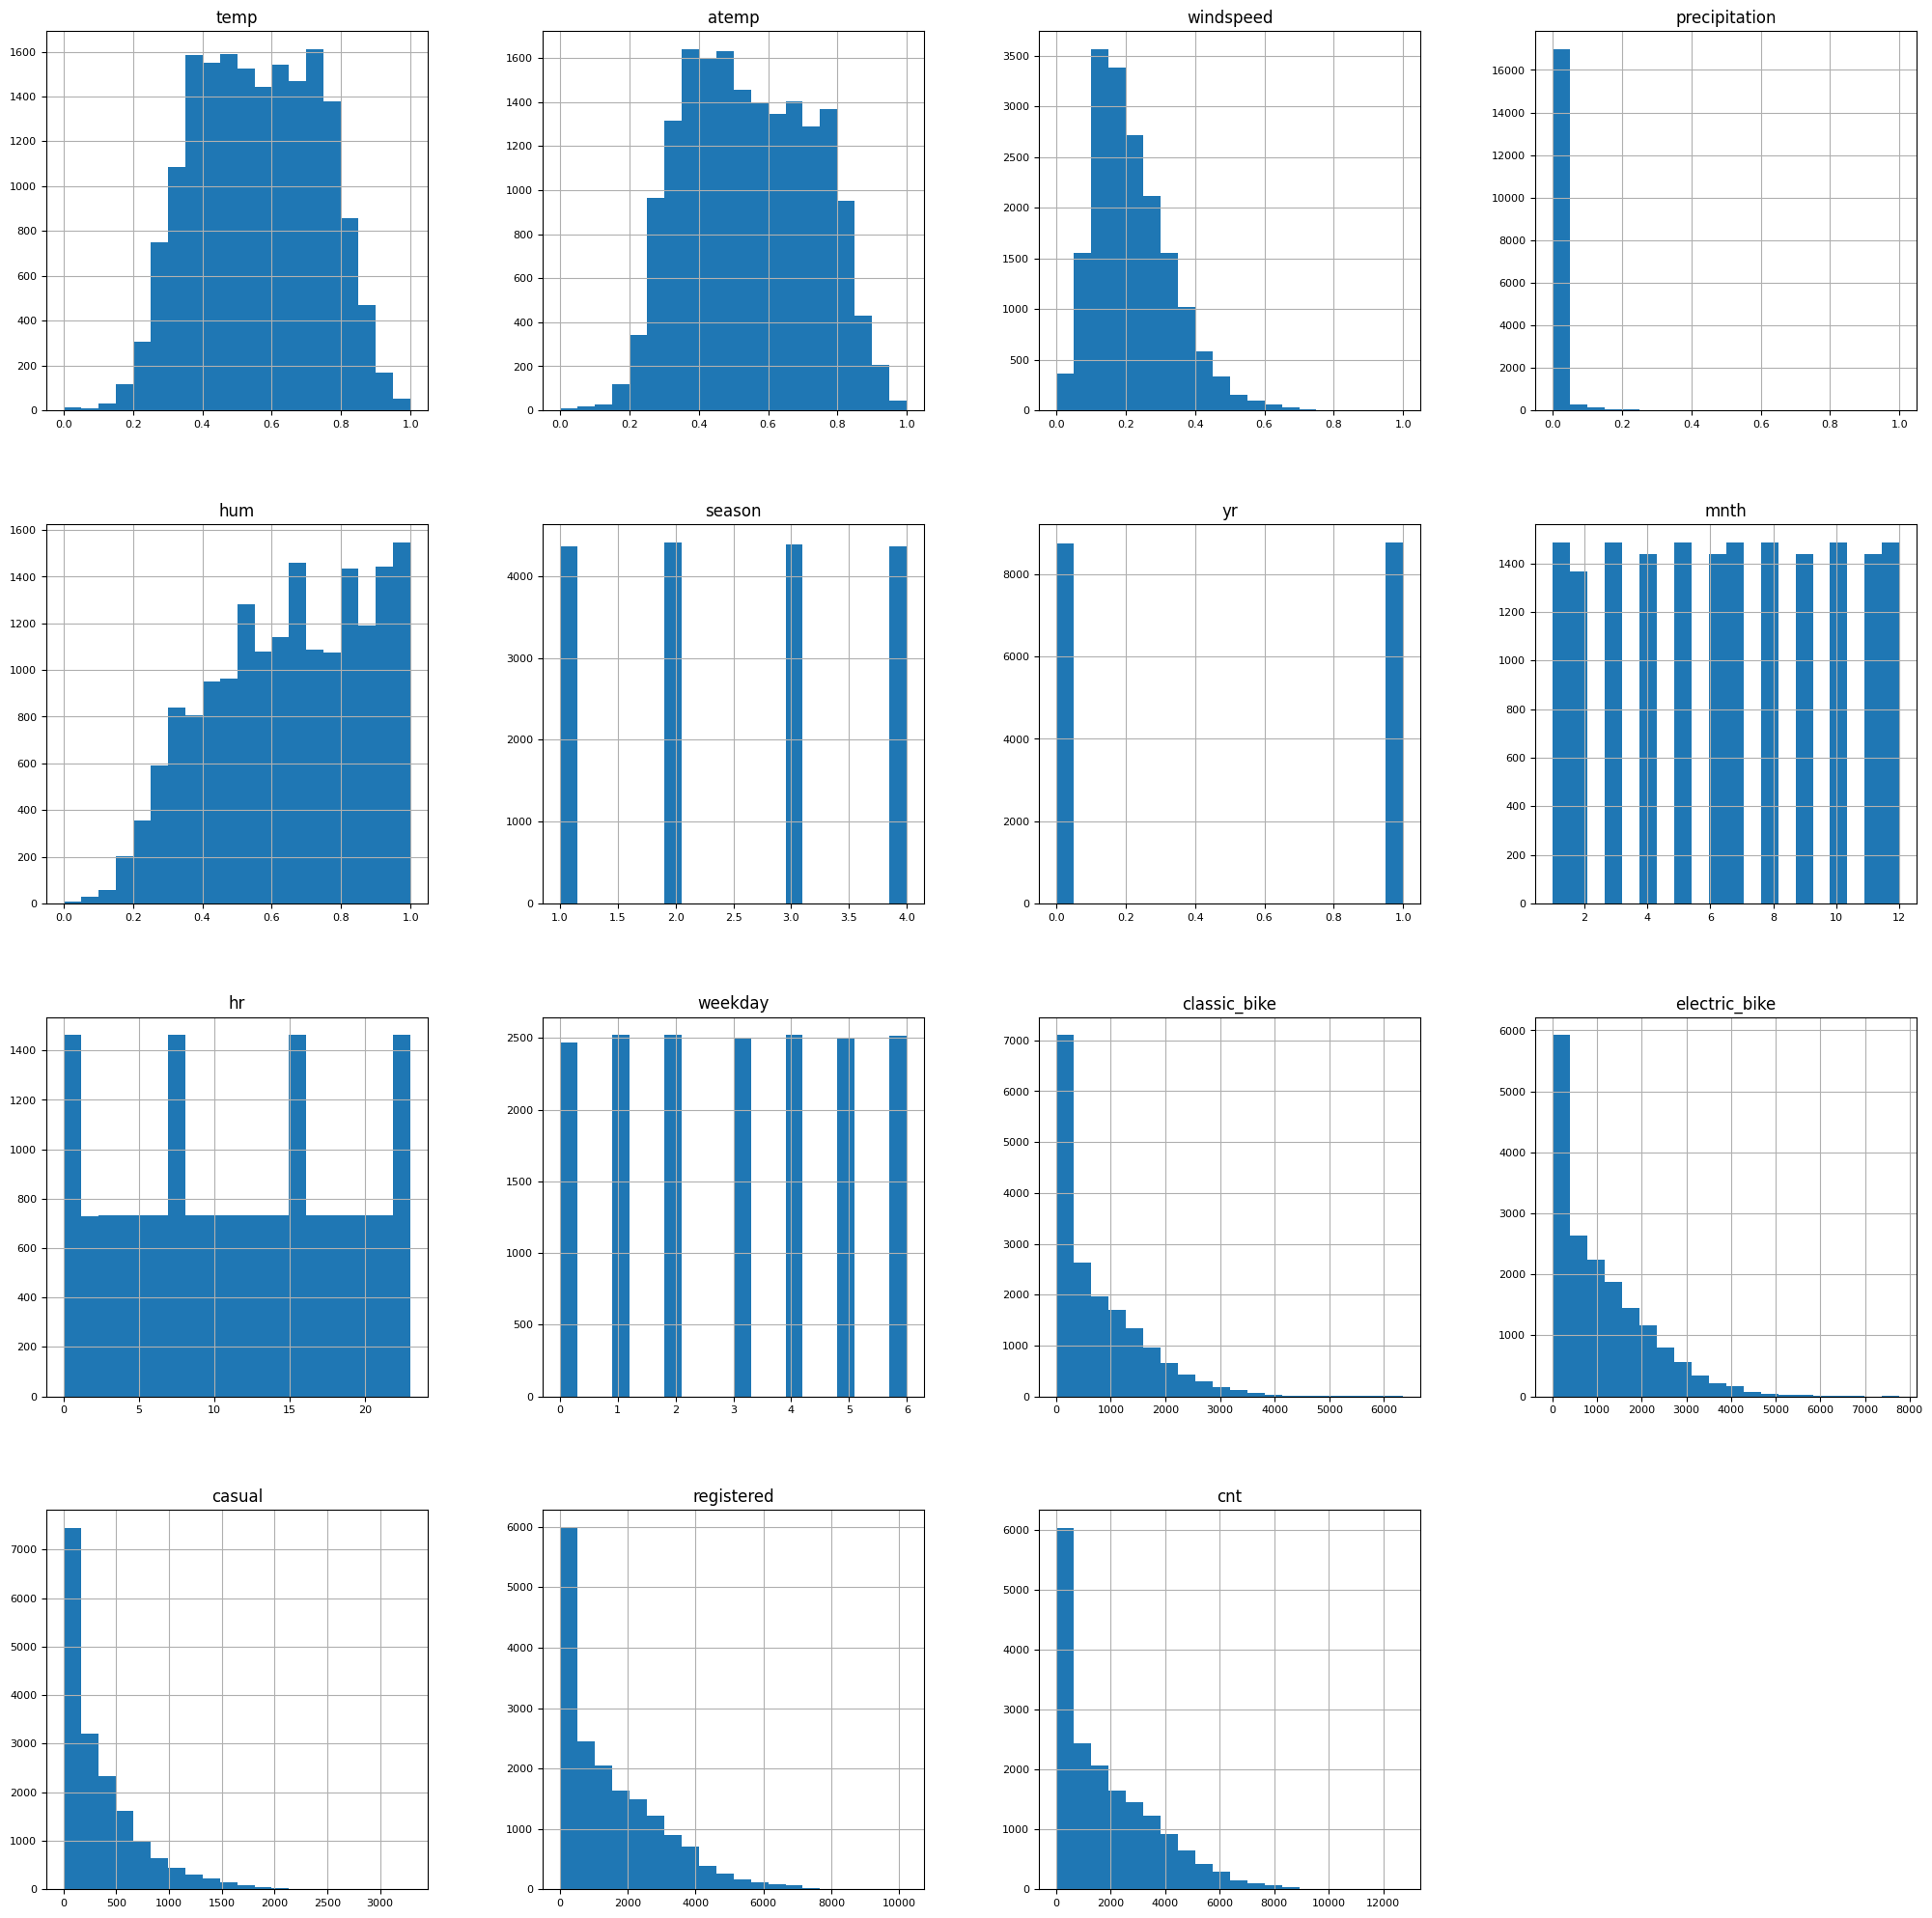

In [13]:
df.hist(figsize=(25, 25), bins=20, xlabelsize=8, ylabelsize=8);

In spite of numeric values, many of the features are in fact categorical (ordinal in some cases).

In [14]:
categorical_columns = ['season', 'yr', 'mnth', 'weekday']
numerical_columns = [x for x in columns if x not in categorical_columns]
numerical_columns

['temp', 'atemp', 'windspeed', 'precipitation', 'hum', 'hr']

We'll create boxplots for categorical feautres and scatterplots for the remaining features.

In [15]:
sns.set_style("darkgrid")

def snsboxplot(df, x_column, y_column, ax):
  sns.boxplot(
    x = x_column,
    y = y_column,
    data = df,
    ax = ax,
    color = 'blue').set(title=f'Pair distribution of {x_column} and {y_column}');
  #plt.show()


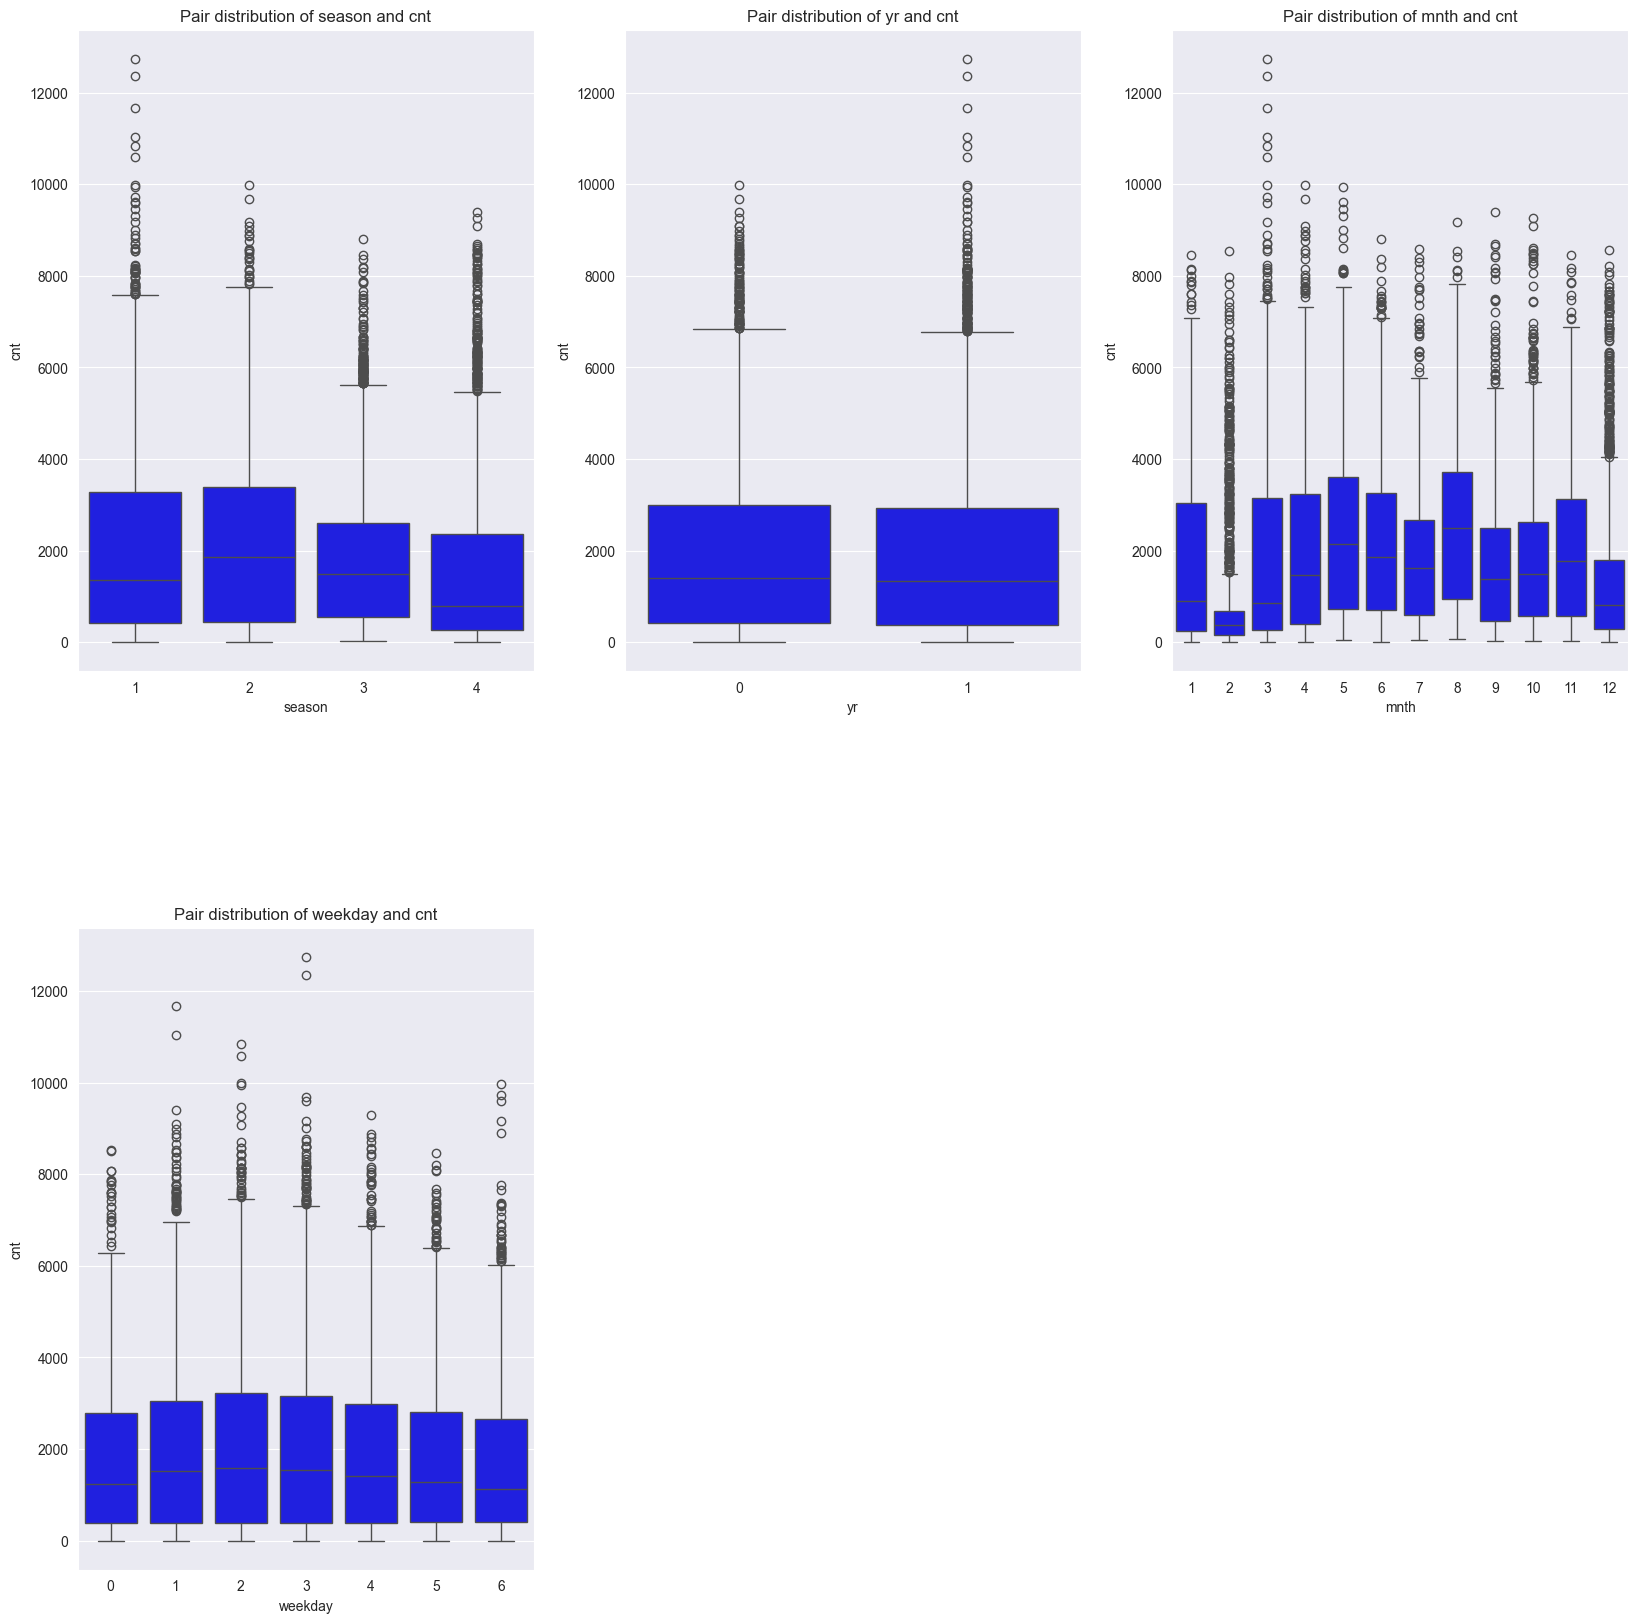

In [16]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
n = len(categorical_columns)

for i, column in enumerate(categorical_columns):
  ax = fig.add_subplot(math.ceil(n/3), 3, i+1)
  snsboxplot(df, column, TARGET, ax)
plt.show()


In [17]:
def sns_scatterplot(df, x_column, y_column, ax):
  sns.scatterplot(
    x = x_column,
    y = y_column,
    data = df,
    ax = ax).set(title=f'Pair distribution of {x_column} and {y_column}');

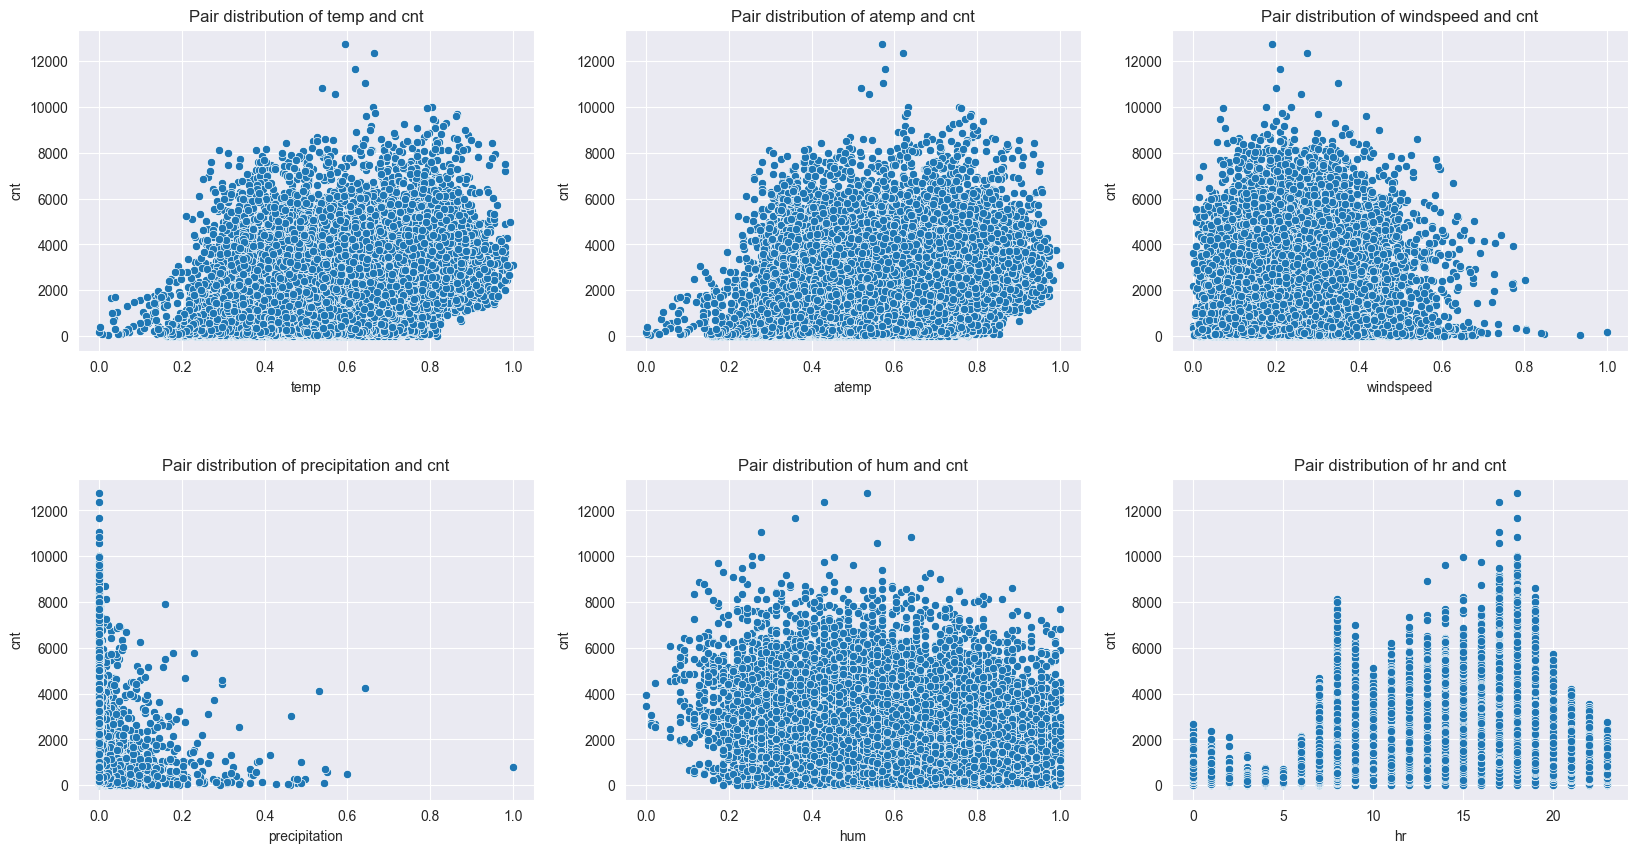

In [18]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
n = len(numerical_columns)

for i, column in enumerate(numerical_columns):
  ax = fig.add_subplot(math.ceil(n/3), 3, i+1)
  sns_scatterplot(df, column, TARGET, ax)
plt.show()


Let's check the correlation matrix of our dataset.

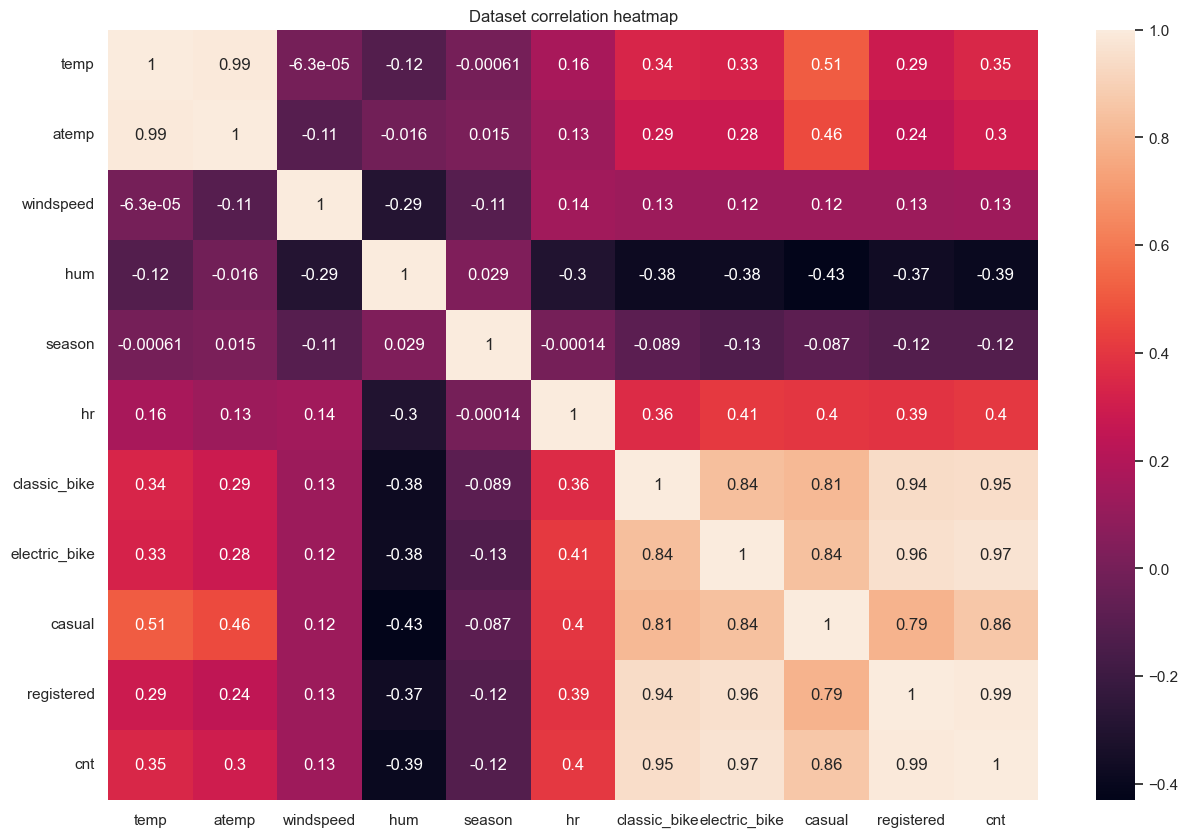

In [19]:
corr = df.corr()
condition = np.abs(corr[TARGET]) > 0.1
top_corr = corr.loc[condition, condition]

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(top_corr, annot=True).set_title("Dataset correlation heatmap");

plt.show()

Obviously the pairs `casual` / `registered` and `classic_bike` / `electric_bike`  are the most correlated with `cnt` because `cnt` is their sum.

Apart from that, some interesting points.

1. Temperature has positive impact on rental count. The higher temperature, the more rentals.
2. Humidity has negative impact on rental count. The higher Humidity (rainy weather), the less rentals.
3. Season has low impact, although we can see from the boxplot above, that there are more rentals in summer and autumn (season=2 and season=3). The hour has more effect on the count. From the scatterplot above we can detect several spikes at hours 8, 17 and 18. Possibly these are the hours when people rent bikes to go to/from work.
4. The temperature and feeling temperature (`temp` and `atemp`) have almost equal impact on the count.

We'll get back to this again while doing feature importance.



#### Useful functions
Some more functions that we'll use later.

In [20]:
def residual_plots(y_pred, y_test):
  errors = y_pred - y_test

  plt.scatter(list(range(len(errors))),errors);
  plt.title("Distibution of errors")
  plt.ylabel('Error');
  plt.xlabel('Index');
  plt.show();

  plt.scatter(y_pred, errors);
  plt.title('Relationship of true value vs error (resudual analysis)')
  plt.ylabel('Error');
  plt.xlabel('True value');
  plt.show();

In [21]:
r2_scores = {}
mae_scores = {}
def print_and_save_scores(y_pred, y_test, model_name):
  r2_scores[model_name] = r2_score(y_pred, y_test)
  mae_scores[model_name] = mean_absolute_error(y_pred, y_test)
  print(f'R2 score: {r2_score(y_pred, y_test):.3f}')
  print(f'MAE score: {mean_absolute_error(y_pred, y_test):.3f}')
  print(f'MSE score: {mean_squared_error(y_pred, y_test):.3f}')

## Preprocessing
Actually no preprocessing is needed here (apart from deleting some columns that we already did) because there are no missing values and the columns are already scaled. 

Let's divide the dataset into train and test sets, allocating 10% for the test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[columns], df[TARGET], random_state=SEED, test_size=0.1)

In [23]:
# X_train = df[df['yr'] == 0]
# X_test = df[df['yr'] == 1]
# y_train = X_train[TARGET]
# y_test = X_test[TARGET]
# X_train = X_train[columns]
# X_test = X_test[columns]
# X_train.head()

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15787 entries, 3379 to 9651
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           15787 non-null  float64
 1   atemp          15787 non-null  float64
 2   windspeed      15787 non-null  float64
 3   precipitation  15787 non-null  float64
 4   hum            15787 non-null  float64
 5   season         15787 non-null  int32  
 6   yr             15787 non-null  int64  
 7   mnth           15787 non-null  int32  
 8   hr             15787 non-null  int32  
 9   weekday        15787 non-null  int32  
dtypes: float64(5), int32(4), int64(1)
memory usage: 1.1 MB


## Building models

### 1. KNN Regressor

First let's find out the optimal number for k.

In [25]:
%%time
train_r2 = []
train_mae = []

test_r2 = []
test_mae = []

for k in range(1, 12):
  knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')
  knn_model.fit(X_train, y_train)
  train_preds = knn_model.predict(X_train)
  train_r2.append(r2_score(y_train, train_preds));
  train_mae.append(mean_absolute_error(y_train, train_preds))

  knn_predictions = knn_model.predict(X_test)
  test_r2.append(r2_score(y_test, knn_predictions));
  test_mae.append(mean_absolute_error(y_test, knn_predictions))


CPU times: total: 2.45 s
Wall time: 2.64 s


In [26]:
sns.set_theme(rc = {'figure.figsize':(8, 5)})
def train_test_score_change(train_scores, test_scores, score_type):
  plt.plot(range(1, 12), train_scores, color = 'blue', label='Train set')
  plt.plot(range(1, 12), test_scores, color = 'red', label='Test set')
  plt.xlabel('K number')
  plt.ylabel(score_type)
  plt.title(score_type + ' change')
  plt.legend()
  plt.show()

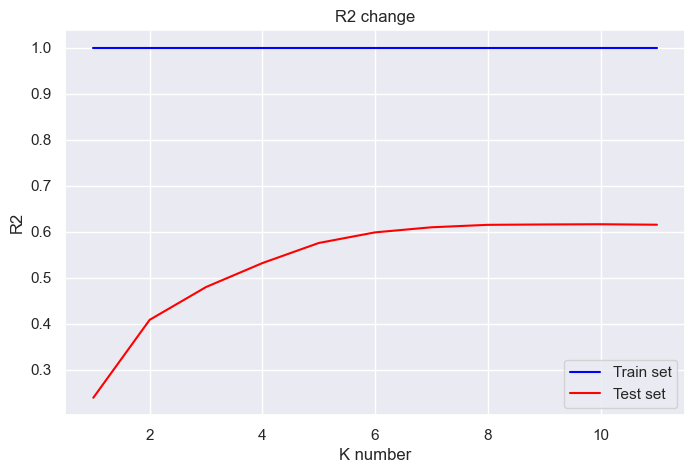

In [27]:
train_test_score_change(train_r2, test_r2, 'R2')

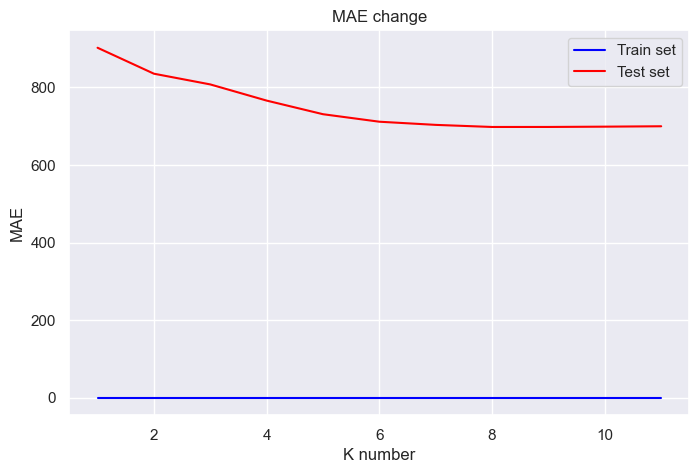

In [28]:
train_test_score_change(train_mae, test_mae, 'MAE')

We can see from the plot that approximately the optimal value is k=6. The scores don't change much after it. Let's check it during Hyperparameters tuning, and then we'll use `hyperopt` library to do that, along with other parameters.

In [29]:
knr = KNeighborsRegressor(n_neighbors=6, weights='distance')
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)
print(f'R2 score: {r2_score(y_pred, y_test)}')
print(f'MSE score: {mean_squared_error(y_pred, y_test)}')
print(f'MAE score: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_pred, y_test)}')

R2 score: 0.419603620706001
MSE score: 1258200.4664588
MAE score: 711.7474906940971
MAPE score: 0.42684832960224883


#### Hyperparameters tuning

In [30]:
%%time
def objective(space):
    params = {
        'n_neighbors': space['n_neighbors'],
        'weights': space['weights'],
        'metric' : space['metric'],
    }

    clf = KNeighborsRegressor(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_absolute_error(predictions, y_test)
    print("Mean absolute error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'n_neighbors': scope.int(hp.quniform('n_estimators', 2, 10, q=1)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'metric': hp.choice('metric', ['minkowski', 'euclidean', 'manhattan']),
    }

knr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Mean absolute error: 620.895, params {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski'}
Mean absolute error: 703.584, params {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski'}
Mean absolute error: 711.747, params {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean'}
Mean absolute error: 699.005, params {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}
Mean absolute error: 588.946, params {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan'}
Mean absolute error: 698.185, params {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}
Mean absolute error: 807.921, params {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski'}
Mean absolute error: 593.364, params {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}
Mean absolute error: 699.005, params {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski'}
Mean absolute error: 698.185, params {'n_neighbors': 8, 'weights': 'distance', 'met

In [31]:
knr_best = space_eval(space, knr_best)
knr_best

{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'uniform'}

We see that `hyperopt` returned 6 as the optimal number.

In [32]:
best_knr = KNeighborsRegressor(**knr_best)
best_knr.fit(X_train, y_train)
y_pred_knr = best_knr.predict(X_test)

print_and_save_scores(y_pred_knr, y_test, 'KNeighborsRegressor')

R2 score: 0.578
MAE score: 588.946
MSE score: 868339.328


We got fair results on R2 and MAE.

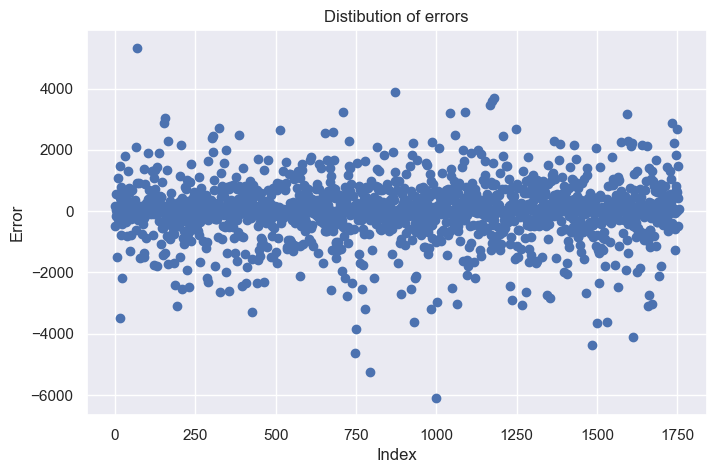

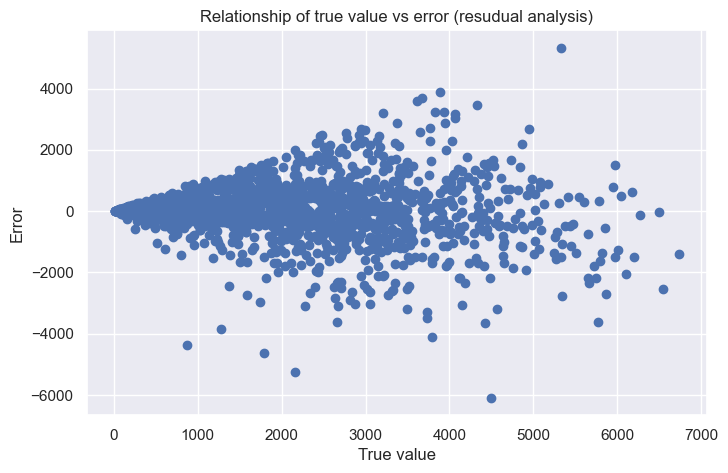

In [33]:
residual_plots(y_pred_knr, y_test)

We see that the error distribution is close to normal, but there is a little heteroskedasticity.

### 2. DecisionTreeRegressor

In [34]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

print_and_save_scores(y_pred_dtr, y_test, 'DecisionTreeRegressor')

R2 score: 0.565
MAE score: 655.675
MSE score: 1402898.190


Very bad result with a negative R2 score, which means that this prediction is worse than if we used the mean value as a prediction.

#### Hyperparameters tuning

In [35]:
%%time
def objective(space):
    params = {
        'criterion': space['criterion'],
        'splitter': space['splitter'],
        'max_depth': space['max_depth'],
        'min_samples_leaf' : space['min_samples_leaf'],
        'min_samples_split' : space['min_samples_split'],
        'max_leaf_nodes' : space['max_leaf_nodes'],
        'max_features' : space['max_features'],
    }

    clf = DecisionTreeRegressor(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_absolute_error(predictions, y_test)
    print("Mean absolute error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, q=1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, q=1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, q=1)),
    'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 2, 100, q=1)),
    'max_features': hp.choice('max_features', ["log2", "sqrt", None]),
    }

dtr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Mean absolute error: 898.967, params {'criterion': 'poisson', 'splitter': 'best', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 14, 'max_leaf_nodes': 51, 'max_features': None}
Mean absolute error: 1143.885, params {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 3, 'max_leaf_nodes': 5, 'max_features': 'sqrt'}
Mean absolute error: 955.003, params {'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 19, 'max_leaf_nodes': 83, 'max_features': 'sqrt'}
Mean absolute error: 1093.440, params {'criterion': 'squared_error', 'splitter': 'random', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 18, 'max_leaf_nodes': 16, 'max_features': 'log2'}
Mean absolute error: 945.982, params {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_leaf_nodes': 83, 'max_features': 'sqrt'}
Mean absolute 

In [36]:
dtr_best = space_eval(space, dtr_best)
dtr_best

{'criterion': 'poisson',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 49,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'splitter': 'best'}

In [37]:
best_dtr = DecisionTreeRegressor(**dtr_best)
best_dtr.fit(X_train, y_train)
y_pred_dtr = best_dtr.predict(X_test)

print_and_save_scores(y_pred_dtr, y_test, 'DecisionTreeRegressor')

R2 score: 0.314
MAE score: 747.437
MSE score: 1257541.884


The result is a bit worse than the one from KNN.

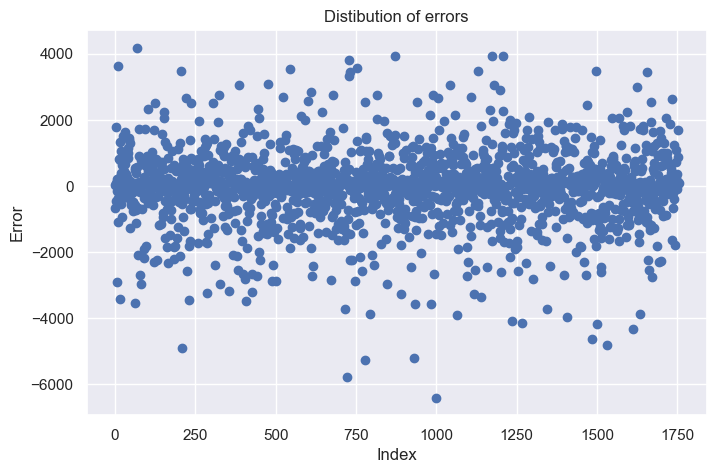

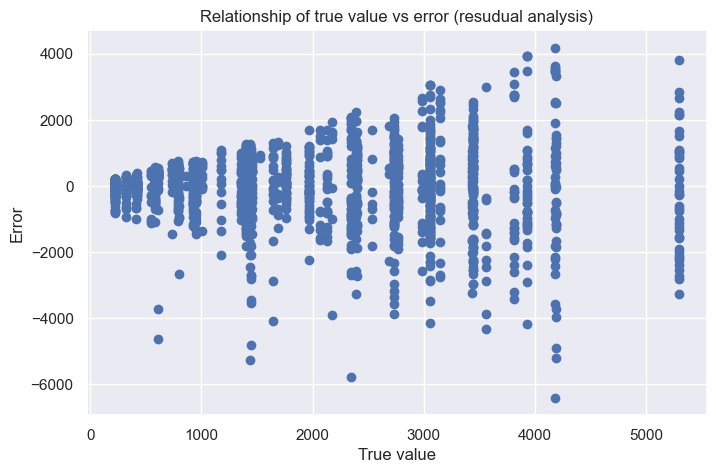

In [38]:
residual_plots(y_pred_dtr, y_test)

Again some heteroskedasticity.

### 3. RandomForestRegressor

In [76]:
rfr = RandomForestRegressor(criterion="squared_error", n_estimators=25, max_depth=20)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

print_and_save_scores(y_pred_rfr, y_test, 'RandomForestRegressor')

R2 score: 0.683
MAE score: 528.508
MSE score: 719900.927


Not a bad result

#### Hyperparameters tuning

In [40]:
%%time
def objective(space):
    params = {
        'criterion': space['criterion'],
        'max_depth': space['max_depth'],
        'min_samples_leaf' : space['min_samples_leaf'],
        'min_samples_split' : space['min_samples_split'],
        'max_features' : space['max_features'],
        'bootstrap' : space['bootstrap'],
    }

    clf = RandomForestRegressor(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_absolute_error(predictions, y_test)
    print("Mean absolute error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'max_depth': scope.int(hp.quniform('max_depth', 20, 100, q=1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, q=1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, q=1)),
    'max_features': hp.choice('max_features', ["log2", "sqrt", None]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    }

rfr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Mean absolute error: 1104.382, params {'criterion': 'friedman_mse', 'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 11, 'max_features': 'log2', 'bootstrap': False}
Mean absolute error: 591.940, params {'criterion': 'squared_error', 'max_depth': 84, 'min_samples_leaf': 9, 'min_samples_split': 13, 'max_features': 'sqrt', 'bootstrap': False}
Mean absolute error: 543.374, params {'criterion': 'poisson', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'max_features': None, 'bootstrap': True}
Mean absolute error: 634.018, params {'criterion': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 3, 'min_samples_split': 18, 'max_features': None, 'bootstrap': False}
Mean absolute error: 627.935, params {'criterion': 'friedman_mse', 'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 9, 'max_features': None, 'bootstrap': False}
Mean absolute error: 600.883, params {'criterion': 'friedman_mse', 'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 11,

In [41]:
rfr_best = space_eval(space, rfr_best)
rfr_best

{'bootstrap': True,
 'criterion': 'poisson',
 'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [42]:
%%time
best_rfr = RandomForestRegressor(**rfr_best)
best_rfr.fit(X_train, y_train)
y_pred_rfr = best_rfr.predict(X_test)

print_and_save_scores(y_pred_rfr, y_test, 'RandomForestRegressor')

R2 score: 0.654
MAE score: 545.406
MSE score: 752369.445
CPU times: total: 10.6 s
Wall time: 11.5 s


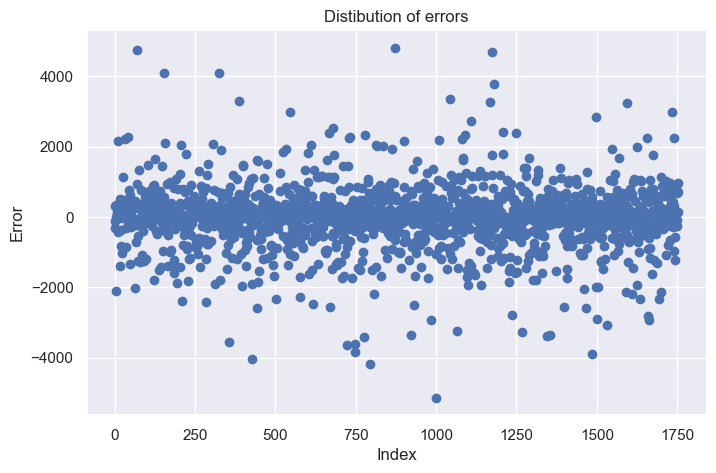

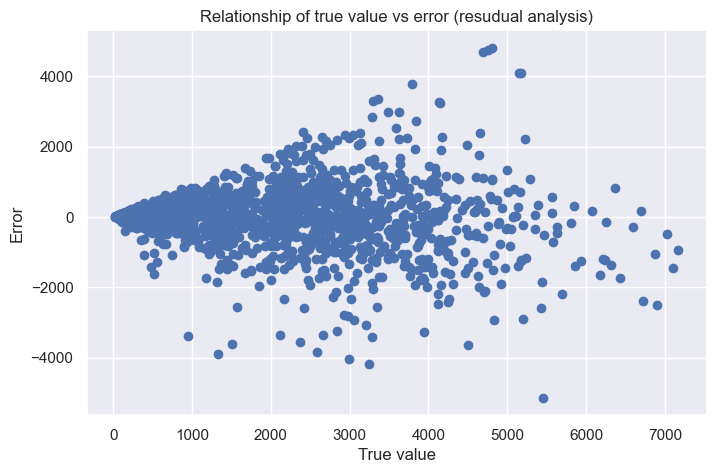

In [43]:
residual_plots(y_pred_rfr, y_test)

Again some heteroskedasticity.

### 4. SVR

In [44]:
%%time
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print_and_save_scores(y_pred_svr, y_test, 'SVR')

R2 score: -6.048
MAE score: 1084.305
MSE score: 2478769.236
CPU times: total: 13.1 s
Wall time: 13.8 s


Not very good results before tuning.

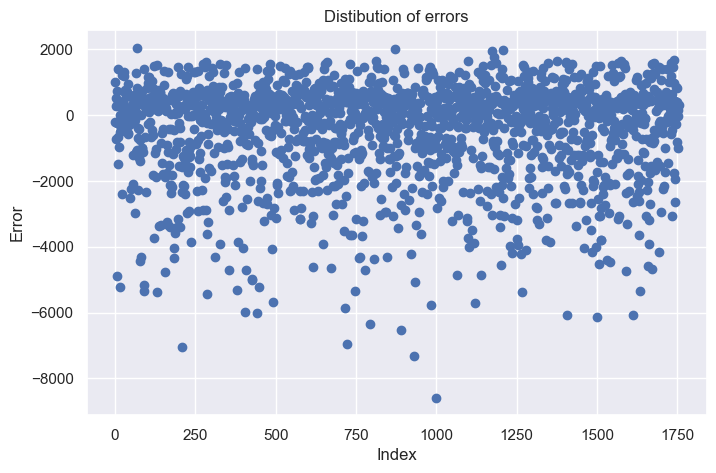

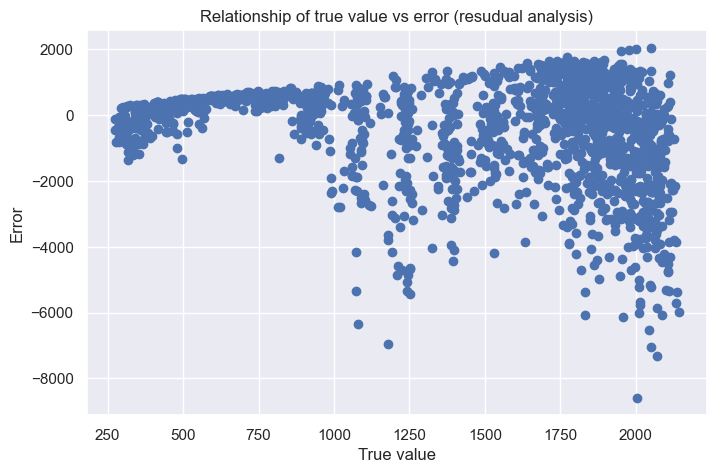

In [45]:
residual_plots(y_pred_svr, y_test)

Again some heteroskedasticity.

#### Hyperparameters tuning


In [48]:
%%time
def objective(space):
    params = {
        'C': space['C'],
        'epsilon': space['epsilon'],
        #'kernel' : space['kernel'],
    }

    clf = SVR(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_squared_error(predictions, y_test)
    print("Mean squared error: {:.0f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'C': hp.choice('C', np.logspace(-1, 6, 8)), # 0.1 to 1,000,0000
    'epsilon': hp.choice('epsilon', np.logspace(-3, 1, 5)), # 0.001 to 1
    #'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid']),
    }

svr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Mean squared error: 1572005, params {'C': 10000.0, 'epsilon': 0.001}
Mean squared error: 1940605, params {'C': 10.0, 'epsilon': 0.001}               
Mean squared error: 1681764, params {'C': 1000.0, 'epsilon': 0.01}              
Mean squared error: 3161182, params {'C': 0.1, 'epsilon': 10.0}                 
Mean squared error: 1454165, params {'C': 100000.0, 'epsilon': 0.1}             
Mean squared error: 1940603, params {'C': 10.0, 'epsilon': 0.1}                 
Mean squared error: 2479181, params {'C': 1.0, 'epsilon': 1.0}                  
Mean squared error: 2478776, params {'C': 1.0, 'epsilon': 0.01}                 
Mean squared error: 2478777, params {'C': 1.0, 'epsilon': 0.001}                
Mean squared error: 1301291, params {'C': 1000000.0, 'epsilon': 1.0}            
100%|██████████| 10/10 [05:52<00:00, 35.28s/trial, best loss: 1301290.6841564656]
CPU times: total: 5min 30s
Wall time: 5min 52s


In [49]:
svr_best = space_eval(space, svr_best)
svr_best

{'C': 1000000.0, 'epsilon': 1.0}

In [50]:
%%time
best_svr = SVR(**svr_best)
best_svr.fit(X_train, y_train)
y_pred_svr = best_svr.predict(X_test)

print_and_save_scores(y_pred_svr, y_test, 'SVR')

R2 score: 0.202
MAE score: 697.353
MSE score: 1301290.684
CPU times: total: 3min 9s
Wall time: 3min 19s


The results are better, but still poor.

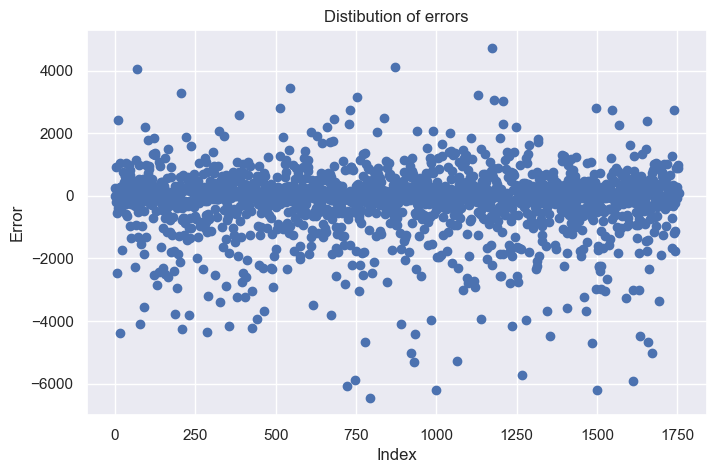

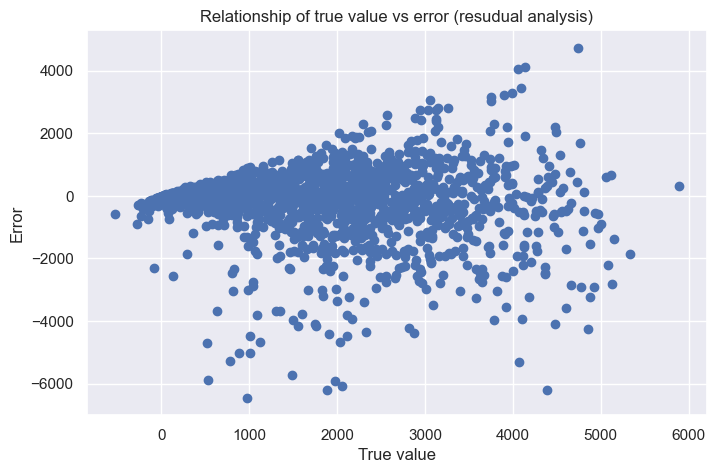

In [51]:
residual_plots(y_pred_svr, y_test)

### 5. AdaBoostRegressor

In [52]:
abr_base_estimator = DecisionTreeRegressor(criterion="squared_error", max_depth=5, min_samples_split=10)
abr = AdaBoostRegressor(estimator=abr_base_estimator, n_estimators=25)
abr.fit(X_train, y_train)
y_pred_abr = abr.predict(X_test)

print_and_save_scores(y_pred_abr, y_test, 'AdaBoostRegressor')

R2 score: 0.229
MAE score: 849.998
MSE score: 1358825.960


#### Hyperparameters tuning

In [53]:
%%time
def objective(space):
    params = {
        'n_estimators': space['n_estimators'],
        'learning_rate': space['learning_rate'],
        'loss' : space['loss'],
    }

    clf = AdaBoostRegressor(random_state = SEED, estimator=abr_base_estimator, **params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_squared_error(predictions, y_test)
    print("Mean squared error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'n_estimators': scope.int(hp.quniform('min_samples_leaf', 10, 100, q=1)),
    'learning_rate': hp.choice('learning_rate', np.logspace(-3, 2, 7)), # 0.001 to 100
    'loss': hp.choice('loss', ['linear', 'square', 'exponential']),
    }

abrr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Mean squared error: 121532624.736, params {'n_estimators': 85, 'learning_rate': 100.0, 'loss': 'square'}
Mean squared error: 1561651.597, params {'n_estimators': 56, 'learning_rate': 0.006812920690579615, 'loss': 'square'}
Mean squared error: 115066042.082, params {'n_estimators': 31, 'learning_rate': 14.677992676220706, 'loss': 'square'}
Mean squared error: 1376165.634, params {'n_estimators': 55, 'learning_rate': 0.31622776601683794, 'loss': 'square'}
Mean squared error: 2840508.583, params {'n_estimators': 97, 'learning_rate': 2.1544346900318843, 'loss': 'square'}
Mean squared error: 1538613.740, params {'n_estimators': 30, 'learning_rate': 0.006812920690579615, 'loss': 'linear'}
Mean squared error: 1481367.533, params {'n_estimators': 87, 'learning_rate': 0.046415888336127795, 'loss': 'linear'}
Mean squared error: 1367257.645, params {'n_estimators': 69, 'learning_rate': 0.31622776601683794, 'loss': 'square'}
Mean squared error: 1563852.465, params {'n_estimators': 43, 'learning_ra

In [54]:
abr_best = space_eval(space, abrr_best)
abr_best

{'learning_rate': 0.31622776601683794, 'loss': 'square', 'n_estimators': 69}

In [55]:
best_abr = AdaBoostRegressor(**abr_best)
best_abr.fit(X_train, y_train)
y_pred_abr = best_abr.predict(X_test)

print_and_save_scores(y_pred_abr, y_test, 'AdaBoostRegressor')

R2 score: -0.074
MAE score: 1010.074
MSE score: 1813052.222


Results are not great here.

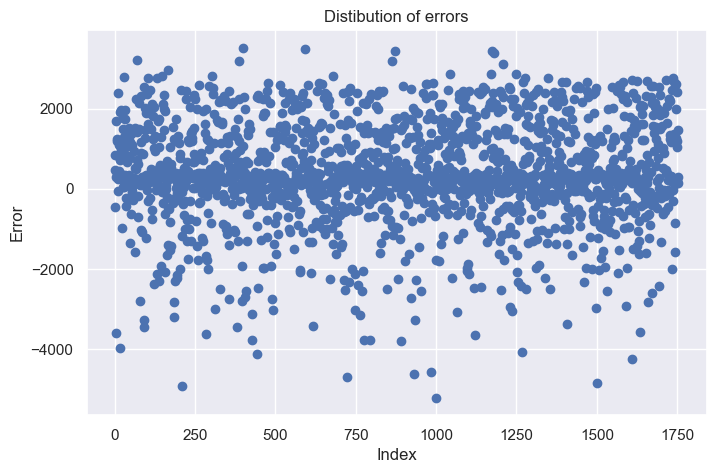

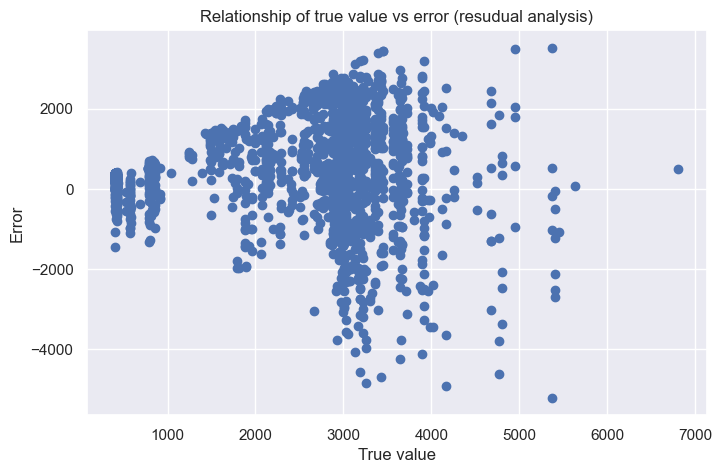

In [56]:
residual_plots(y_pred_abr, y_test)

### Compare scores

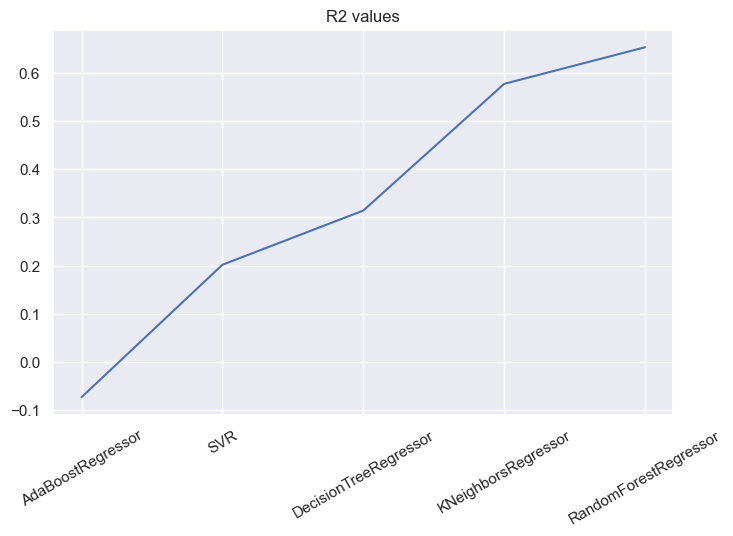

In [57]:
lists = sorted(r2_scores.items(), key=lambda x:x[1]) # sorted by value, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('R2 values')
plt.xticks(rotation=30)
plt.show()

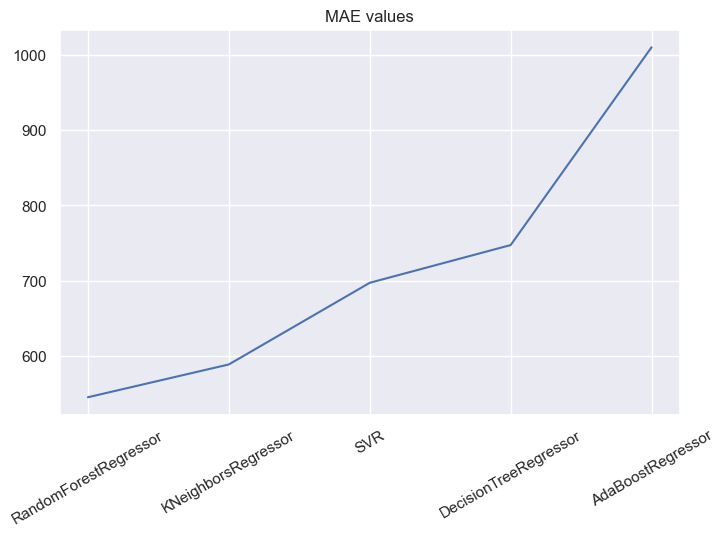

In [58]:
lists = sorted(mae_scores.items(), key=lambda x:x[1]) # sorted by value, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('MAE values')
plt.xticks(rotation=30)
plt.show()

RandomForestRegressor is the best in both cases - highest R2 and lowest MAE. Let's print its results once again.

In [59]:
print(f'R2 score: {r2_score(y_pred_rfr, y_test)}')
print(f'MAE score: {mean_absolute_error(y_pred_rfr, y_test)}')

R2 score: 0.6536809463985735
MAE score: 545.4063965881163


### Feature importance

In [60]:
best_rfr.feature_importances_

array([0.06918637, 0.05688496, 0.03435787, 0.01956072, 0.05831491,
       0.02981824, 0.01881718, 0.06581487, 0.60043258, 0.0468123 ])

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15787 entries, 3379 to 9651
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           15787 non-null  float64
 1   atemp          15787 non-null  float64
 2   windspeed      15787 non-null  float64
 3   precipitation  15787 non-null  float64
 4   hum            15787 non-null  float64
 5   season         15787 non-null  int32  
 6   yr             15787 non-null  int64  
 7   mnth           15787 non-null  int32  
 8   hr             15787 non-null  int32  
 9   weekday        15787 non-null  int32  
dtypes: float64(5), int32(4), int64(1)
memory usage: 1.1 MB


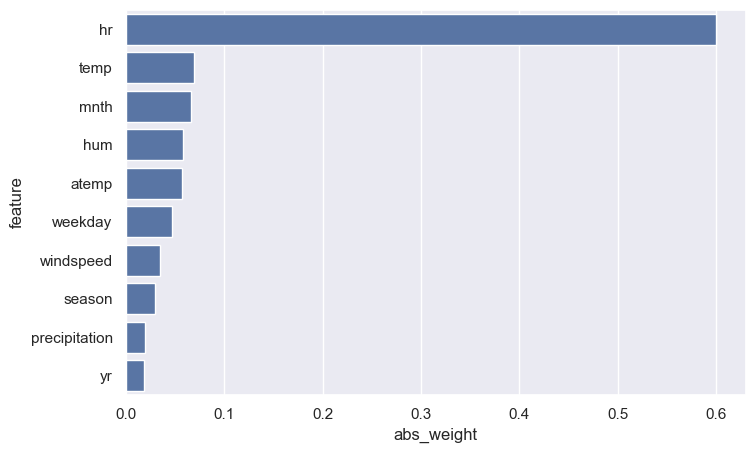

In [62]:
importance = pd.DataFrame({
    'abs_weight': np.abs(best_rfr.feature_importances_),
    'feature': columns
})
importance = importance.sort_values(by='abs_weight', ascending=False)
sns.barplot(y='feature', x='abs_weight', data=importance, orient='h');

* Hour (`hr`) is the most important feauture by far.
* Temperature is a bit more important than the feeling temperature.
* Next two important features are humidity and month. Month has some importance because there are more rentals on summer and autumn. And as we mentioned earlier, humidity has negative impact on rentals count.




### Train the best model on the first year, predict the second

In [63]:
X_first = df[df['yr'] == 0]
X_second = df[df['yr'] == 1]
X_first.head()

,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
0,0.401515,0.381250,0.249564,0.0,0.639535,1,0,12,0,4,357,823,255,925,1180
1,0.395833,0.378125,0.237347,0.0,0.674419,1,0,12,1,4,214,478,159,533,692
2,0.373106,0.370312,0.160558,0.0,0.755814,1,0,12,2,4,114,299,110,303,413
3,0.361742,0.359375,0.158813,0.0,0.779070,1,0,12,3,4,55,217,55,217,272
4,0.346591,0.348438,0.144852,0.0,0.813953,1,0,12,4,4,71,161,48,184,232


In [64]:
X_first.shape, X_second.shape

((8759, 15), (8783, 15))

In [65]:
cnt_first = X_first['cnt']
casual_first = X_first['casual']
registered_first = X_first['registered']

cnt_second = X_second['cnt']
casual_second = X_second['casual']
registered_second = X_second['registered']

In [66]:
X_first = X_first[columns]
X_second = X_second[columns]

In [67]:
X_first.head()

,temp,atemp,windspeed,precipitation,hum,season,yr,mnth,hr,weekday
0,0.401515,0.381250,0.249564,0.0,0.639535,1,0,12,0,4
1,0.395833,0.378125,0.237347,0.0,0.674419,1,0,12,1,4
2,0.373106,0.370312,0.160558,0.0,0.755814,1,0,12,2,4
3,0.361742,0.359375,0.158813,0.0,0.779070,1,0,12,3,4
4,0.346591,0.348438,0.144852,0.0,0.813953,1,0,12,4,4


In [74]:
best_rfr_1 = best_rfr
best_rfr_1.fit(X_first, cnt_first)
cnt_second_pred = best_rfr_1.predict(X_second)
print(f'R2 score: {r2_score(cnt_second_pred, cnt_second)}')
print(f'MAE score: {mean_absolute_error(cnt_second_pred, cnt_second)}')
print(f'MSE score: {mean_squared_error(cnt_second_pred, cnt_second)}')

R2 score: 0.10984371485007971
MAE score: 915.8987768273388
MSE score: 1724066.311773951


We got poor results this way.

### Multitarget regression

We're trying to predict `casual` and `registered` columns at once, doing Multitarget regression.

In [69]:
two_column_train = pd.concat([casual_first, registered_first], axis=1)
two_column_test = pd.concat([casual_second, registered_second], axis=1)
print(two_column_train.shape, two_column_test.shape)

(8759, 2) (8783, 2)


In [70]:
best_rfr_2 = best_rfr
best_rfr_2.fit(X_first, two_column_train)
two_column_pred = best_rfr_2.predict(X_second)
print(f'R2 score: {r2_score(two_column_pred, two_column_test)}')
print(f'MAE score: {mean_absolute_error(two_column_pred, two_column_test)}')


R2 score: 0.1707653980913164
MAE score: 466.26194359473334


Again bad results when we split the dataset based on year.

Let's sum the predictions for the two columns and make it a prediction for `cnt`.

In [71]:
col_totals = [ sum(x) for x in zip(*two_column_pred) ]
col_totals

[3051336.944108799, 13589478.65607871]

In [72]:
one_column_pred = two_column_pred[:,0] + two_column_pred[:,1]

In [73]:
print(f'R2 score: {r2_score(one_column_pred, cnt_second)}')
print(f'MAE score: {mean_absolute_error(one_column_pred, cnt_second)}')

R2 score: 0.14357009083198313
MAE score: 917.3867481869925


Bad results again.

### Conclusion
Overall the results are moderate. The highest R2 score I got is around 0.68, which means that possibly some important factors are missing. For example, I'd like to have also holiday data, i.e. a separate column indicating if the rental event happened during a holiday or not.